# Butterfly Cnn

In [23]:
#import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.callbacks import EarlyStopping

from PIL import Image
import pandas as pd
import requests
import numpy as np

## importing data

In [2]:
#load in datasets
butterfly_df = pd.read_csv('Resources/Training_set.csv')
test_df = pd.read_csv('Resources/Testing_set.csv')
train_path = 'Resources/train/'
test_path = 'Resources/test/'

In [3]:
butterfly_df.head(5)

filename                     label
0  Image_1.jpg          SOUTHERN DOGFACE
1  Image_2.jpg                    ADONIS
2  Image_3.jpg            BROWN SIPROETA
3  Image_4.jpg                   MONARCH
4  Image_5.jpg  GREEN CELLED CATTLEHEART

In [4]:
len(butterfly_df)

6499

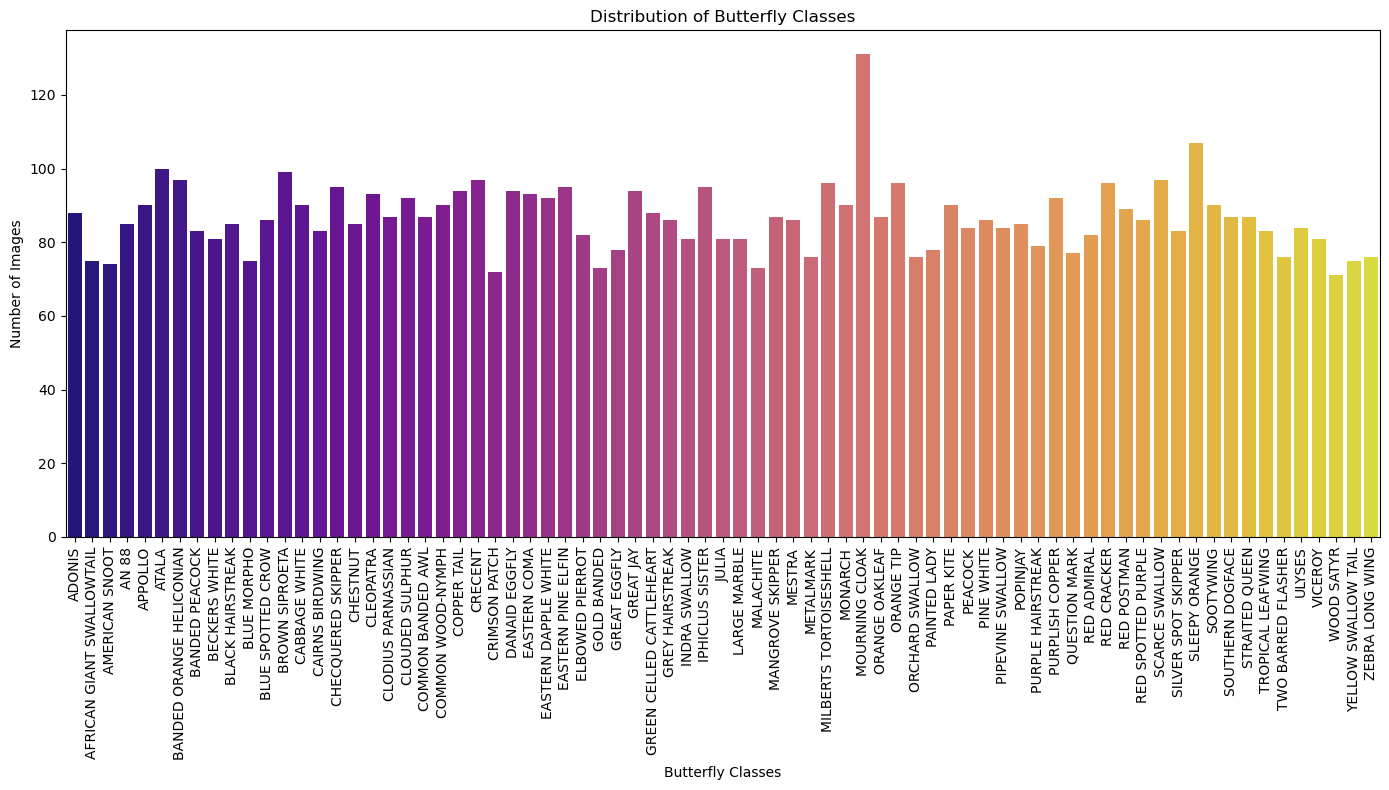

In [5]:
classes = butterfly_df['label'].value_counts().sort_index()

plt.figure(figsize=(14, 8))
sns.barplot(x=classes.index, y=classes.values, palette='plasma')
plt.title('Distribution of Butterfly Classes')
plt.xlabel('Butterfly Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [6]:
#path is labeled as train_path in cell 2
images = []


for i in range(len(butterfly_df)):
    filename = butterfly_df.iloc[i, 0]
    path = os.path.join(train_path, filename)
    print(f'{i + 1} of {len(butterfly_df)}: Attempting to import {filename}')
    
    if not os.path.exists(path):
        print(f'FAILED: {filename} does not exist at {path}')
        continue

    try:
        # Use context manager to automatically close the file after opening
        with Image.open(path) as img:
            img = img.convert("RGB")  # Standardize to RGB
            images.append(img.copy())  # Append a copy of the image to close original
    except (IOError, SyntaxError, OSError) as e:
        print(f'FAILED to import {filename} at index {i + 1}, Error: {e}')

1 of 6499: Attempting to import Image_1.jpg
2 of 6499: Attempting to import Image_2.jpg
3 of 6499: Attempting to import Image_3.jpg
4 of 6499: Attempting to import Image_4.jpg
5 of 6499: Attempting to import Image_5.jpg
6 of 6499: Attempting to import Image_6.jpg
7 of 6499: Attempting to import Image_7.jpg
8 of 6499: Attempting to import Image_8.jpg
9 of 6499: Attempting to import Image_9.jpg
10 of 6499: Attempting to import Image_10.jpg
11 of 6499: Attempting to import Image_11.jpg
12 of 6499: Attempting to import Image_12.jpg
13 of 6499: Attempting to import Image_13.jpg
14 of 6499: Attempting to import Image_14.jpg
15 of 6499: Attempting to import Image_15.jpg
16 of 6499: Attempting to import Image_16.jpg
17 of 6499: Attempting to import Image_17.jpg
18 of 6499: Attempting to import Image_18.jpg
19 of 6499: Attempting to import Image_19.jpg
20 of 6499: Attempting to import Image_20.jpg
21 of 6499: Attempting to import Image_21.jpg
22 of 6499: Attempting to import Image_22.jpg
23 of 

## Preprocessing

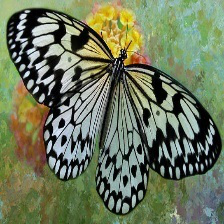

In [7]:
# Print a random image from the list to ensure the import was successful
images[6423]

In [8]:
# Check the size of the second image
images[1].size

(224, 224)

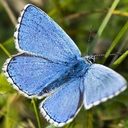

In [9]:
#if I need to make it smaller if my machine is not up to par for doing it with 224 by 224.
#it will be more accurate at that size though. Also can do 128 by 128

# Get all the sizes into a list, then convert to a set
sizes = set([img.size for img in images])
sizes
# Use a for loop to resize all images to 64 by 60
target_size = (128, 128)

resized_images = [img.resize(target_size, resample = Image.LANCZOS) for img in images]
resized_images[1]

In [10]:
# Convert all images to floating point numpy arrays
float_images = [np.array(img).astype(np.float32) for img in resized_images]

# Display the pixel values of the first image
print("Pixel Values:")
print(float_images[0])

Pixel Values:
[[[ 25.  43.  31.]
  [ 26.  42.  29.]
  [ 27.  43.  29.]
  ...
  [ 24.  36.  17.]
  [ 38.  51.  26.]
  [ 48.  61.  35.]]

 [[ 25.  45.  29.]
  [ 24.  44.  25.]
  [ 26.  43.  24.]
  ...
  [ 45.  54.  32.]
  [ 60.  70.  43.]
  [ 66.  76.  47.]]

 [[ 22.  45.  27.]
  [ 22.  43.  24.]
  [ 23.  42.  23.]
  ...
  [ 67.  75.  48.]
  [ 83.  91.  59.]
  [ 87.  94.  60.]]

 ...

 [[ 61.  99.  63.]
  [ 70. 111.  67.]
  [100. 135.  79.]
  ...
  [ 41.  60.  28.]
  [ 54.  74.  37.]
  [ 60.  81.  40.]]

 [[ 63.  98.  65.]
  [ 71. 110.  68.]
  [ 99. 133.  78.]
  ...
  [ 34.  53.  20.]
  [ 40.  62.  22.]
  [ 43.  66.  21.]]

 [[ 68. 103.  69.]
  [ 75. 113.  73.]
  [106. 140.  86.]
  ...
  [ 35.  57.  19.]
  [ 41.  64.  19.]
  [ 44.  68.  19.]]]


In [11]:
# To normalize images to a range between 0 and 1,
# we need to divide all pixel values by the max of 255

normalized_images = [img/255 for img in float_images]

# Display the pixel values of the first image
print("Pixel Values:")
print(normalized_images[0])

Pixel Values:
[[[0.09803922 0.16862746 0.12156863]
  [0.10196079 0.16470589 0.11372549]
  [0.10588235 0.16862746 0.11372549]
  ...
  [0.09411765 0.14117648 0.06666667]
  [0.14901961 0.2        0.10196079]
  [0.1882353  0.23921569 0.13725491]]

 [[0.09803922 0.1764706  0.11372549]
  [0.09411765 0.17254902 0.09803922]
  [0.10196079 0.16862746 0.09411765]
  ...
  [0.1764706  0.21176471 0.1254902 ]
  [0.23529412 0.27450982 0.16862746]
  [0.25882354 0.29803923 0.18431373]]

 [[0.08627451 0.1764706  0.10588235]
  [0.08627451 0.16862746 0.09411765]
  [0.09019608 0.16470589 0.09019608]
  ...
  [0.2627451  0.29411766 0.1882353 ]
  [0.3254902  0.35686275 0.23137255]
  [0.34117648 0.36862746 0.23529412]]

 ...

 [[0.23921569 0.3882353  0.24705882]
  [0.27450982 0.43529412 0.2627451 ]
  [0.39215687 0.5294118  0.30980393]
  ...
  [0.16078432 0.23529412 0.10980392]
  [0.21176471 0.2901961  0.14509805]
  [0.23529412 0.31764707 0.15686275]]

 [[0.24705882 0.38431373 0.25490198]
  [0.2784314  0.4313725

## Labels

In [12]:
# Print the first few image filenames
butterfly_df.head()

filename                     label
0  Image_1.jpg          SOUTHERN DOGFACE
1  Image_2.jpg                    ADONIS
2  Image_3.jpg            BROWN SIPROETA
3  Image_4.jpg                   MONARCH
4  Image_5.jpg  GREEN CELLED CATTLEHEART

In [13]:
# First, remove the .jpg file extension, then split into new columns. 
# Remove the .jpg extension
butterfly_df['filename'] = butterfly_df['filename'].str.replace('.jpg', '', regex=False)
butterfly_df.head()

filename                     label
0  Image_1          SOUTHERN DOGFACE
1  Image_2                    ADONIS
2  Image_3            BROWN SIPROETA
3  Image_4                   MONARCH
4  Image_5  GREEN CELLED CATTLEHEART

In [14]:
# Now we can call our preprocessed pixel data 'X'
X = normalized_images

# For our purposes, we'll select the label column as 'y'
y = butterfly_df['label']

In [15]:
# Check the total number of classes
y.nunique()

75

In [16]:
X = np.array(X)
y = np.array(y)

In [17]:
# Now we'll split our data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

## Augmentation

In [18]:
# Apply augmentation to the whole training dataset
# Define the augmentation pipeline

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1),         # Rotate by 10%
    tf.keras.layers.RandomTranslation(0.1, 0.1), # Shift horizontally and vertically by 10%
    tf.keras.layers.RandomZoom(0.1),             # Zoom in/out by 10%
    tf.keras.layers.RandomFlip('horizontal')     # Random horizontal flip
])

# Create variables to hold the X and y training data
X_train_aug = []
y_train_aug = []

# Loop through all the images.
for i in range(len(X_train)):
    # Select the image
    img = X_train[i]
    # Select the label from the training data
    label = y_train[i]

    # Ensure that the input data has the correct shape
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Add 5 images for every original image
    for j in range(5):
        # Append a new image to the X list
        X_train_aug.append(data_augmentation(img, training=True)[0].numpy())
        # Append the label for the original image to the y list
        y_train_aug.append(label)

# Print the length of each list
print(len(X_train_aug))
print(len(y_train_aug))

24370
24370


In [19]:
# Reshape test data for the model
X_test_np = []
for img in X_test:
    # Append the image to the list
    X_test_np.append(img)

# Convert to numpy array
X_test_np = np.array(X_test_np)

# Check the shape of the first image
X_test_np[0].shape

(128, 128, 3)

## Creating the Model

In [20]:
# One hot encode the y data
y_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(np.array(y_train_aug).reshape(-1, 1))
y_train_aug_enc = y_encoder.transform(np.array(y_train_aug).reshape(-1, 1))
y_test_enc = y_encoder.transform(np.array(y_test).reshape(-1, 1))

# Convert values to numpy arrays
X_train_aug_np = np.array(X_train_aug)
X_test_np = np.array(X_test_np)
y_train_aug_np = np.array(y_train_aug_enc)
y_test_np = np.array(y_test_enc)

# Load and preprocess your CMU Face Images dataset (Ensure each image is labeled as "with sunglasses" or "without sunglasses")
# The following code assumes that you have already loaded and preprocessed your dataset into 'X' and 'y' (features and labels).

# Split the training dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_aug_np, y_train_aug_np, test_size=0.2, random_state=42)

# Print the total number of one_hot_encoded columns
np.array(y_train).shape

(19496, 75)

In [26]:
# Define the learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',          # Monitors validation loss
    patience=3,                  # Stops if no improvement in 3 epochs
    restore_best_weights=True    # Restores best weights if stopped early
)

In [27]:
# Define a CNN model
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(75, activation='softmax')
])

# Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Define early stopping with patience of 3 epochs
model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 92s 149ms/step - accuracy: 0.0509 - loss: 4.0113 - val_accuracy: 0.3034 - val_loss: 2.6633
Epoch 2/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 92s 150ms/step - accuracy: 0.2825 - loss: 2.6895 - val_accuracy: 0.5217 - val_loss: 1.7437
Epoch 3/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 98s 160ms/step - accuracy: 0.4423 - loss: 1.9664 - val_accuracy: 0.6336 - val_loss: 1.3151
Epoch 4/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 98s 161ms/step - accuracy: 0.5551 - loss: 1.5234 - val_accuracy: 0.6678 - val_loss: 1.1544
Epoch 5/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 99s 163ms/step - accuracy: 0.6146 - loss: 1.2804 - val_accuracy: 0.7187 - val_loss: 0.9794
Epoch 6/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 98s 160ms/step - accuracy: 0.6622 - loss: 1.0904 - val_accuracy: 0.7464 - val_loss: 0.8762
Epoch 7/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 100s 164ms/step - accuracy: 0.7067 - loss: 0.9387 - val_accuracy: 0.7733 - val_loss: 0.7831
Epoch 8/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 100s 163ms/step - accuracy: 0.7375 - loss:

In [28]:
#evaluate the model
model.evaluate(X_test_np, y_test_np)

51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7038 - loss: 1.3662


[1.3327332735061646, 0.7150769233703613]

In [31]:
model = model.save('butterfly_model.keras')

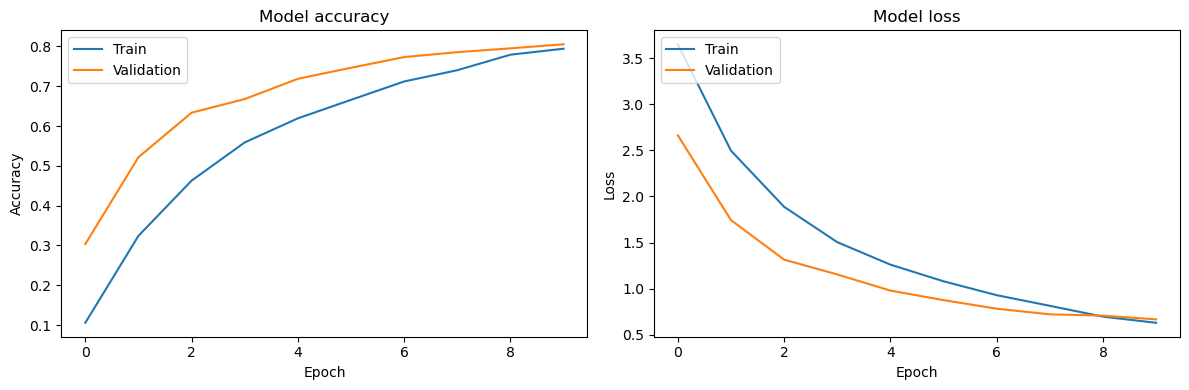

In [32]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()